This problem was asked by Twitter.

Implement an autocomplete system. That is, given a query string s and a set of all possible query strings, return all strings in the set that have s as a prefix.

For example, given the query string de and the set of strings [dog, deer, deal], return [deer, deal].

Hint: Try preprocessing the dictionary into a more efficient data structure to speed up queries.

In [5]:
import re

def matchPrefixInList(l, prefix=''):
    """ Return all strings in list l that start with prefix.
    Time complexity is O(n) and space complexity is O(1). """
    return [string for string in l if re.match("^" + prefix, string)]

class Node:
    def __init__(self, nextchars=None):
        self.nextchars = nextchars if nextchars is not None else {}

def makeTreeFromList(l):
    """ Make a tree of characters from a list of strings, and 
    return the root of the tree.
    
    This data structure makes it a lot faster to search for a string that
    starts with a certain prefix string.
    
    Root of the tree is the empty character, children nodes 
    are all the possible first characters that exist in the list of strings,
    grandchildren nodes are all the possible second caracters given
    the first character, etc.
    
    Time complexity is O(n*str_len). """
    root = Node()
    for string in l:
        # start at root node for every new string
        node = root
        for char in string:
            if char not in node.nextchars:
                # add a child node for every newly encountered character
                node.nextchars[char] = Node()
            # move to child node
            node = node.nextchars[char]
        # end with an empty-character node for every end of string
        node.nextchars[''] = Node()
    return root

def makeCollectionFromTree(root, prefix=''):
    """ Returns a collection of all the strings contained in tree,
    starting from root node and prepending the prefix string.
    Time complexity is O(alphabet_size*str_len). """
    for char in root.nextchars:
        # iterate over all the possible children nodes (i.e. next characters)
        if char == '':
            # reached the end of a string. yield it.
            yield prefix
        else:
            # if not, append child node character to prefix and recurse on child node.
            yield from makeCollectionFromTree(root.nextchars[char], prefix + char)

def matchPrefixInTree(node, prefix=''):
    """ Return a collection of all strings in tree (starting from node),
    that start with prefix.
    Time complexity is O(alphabet_size*str_len). """
    # First, travel the the appropriate child node dictated by prefix
    # (or return an empty collection if child node doesn't exist).
    for char in prefix:
        if char not in node.nextchars:
            # no match
            return ()
        node = node.nextchars[char]
    # Return the collection of strings starting from current node,
    # prepended with prefix string.
    return makeCollectionFromTree(node, prefix)

In [6]:
l = ["eden", "dog", "deer", "deal", "dealer"]
prefix = "de"

print(matchPrefixInList(l, prefix))

root = makeTreeFromList(l)
print(root.nextchars['d'].nextchars['e'].nextchars['a'].nextchars['l'].nextchars)
print(list(matchPrefixInTree(root, prefix)))

['deer', 'deal', 'dealer']
{'': <__main__.Node object at 0x7fdb3c17d090>, 'e': <__main__.Node object at 0x7fdb3c17d0d0>}
['deer', 'deal', 'dealer']


In [7]:
import itertools
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import math

def runtime(fun, arg):
    """ Return the execution time of fun with argument arg """
    start = timer()
#     print(fun(arr))
    res = fun(arg)
    end = timer()
    return end-start

def benchmark(fun, min_str_len=1, max_str_len=7, n=7):
    """ 
    Benchmark runtime of function fun with lists of varying length. 
    Return a DataFrame specifying execution times in seconds for a
    set of list lengths.
    """
    bench_df = pd.DataFrame({
        'len': np.empty(n),
        'str_len': range(min_str_len, max_str_len+1),
        'execution_time': np.empty(n)
    })
    alphabet = [chr(i) for i in range(ord('a'), ord('z')+1)]
    for i, n in enumerate(bench_df['str_len']):
        l = [''.join(tup) for tup in itertools.combinations(alphabet, n)]
        bench_df.at[i, 'len'] = len(l)
        if fun == matchPrefixInTree:
            root = makeTreeFromList(l)
            bench_df.at[i, 'execution_time'] = runtime(fun,root)
        else:
            bench_df.at[i, 'execution_time'] = runtime(fun,l)
    return bench_df

In [8]:
matchList_stats_df = benchmark(matchPrefixInList)
matchList_stats_df

,len,str_len,execution_time
0,26.0,1,0.000166
1,325.0,2,0.000761
2,2600.0,3,0.005736
3,14950.0,4,0.022942
4,65780.0,5,0.059927
5,230230.0,6,0.189289
6,657800.0,7,0.530337


In [9]:
makeTree_stats_df = benchmark(makeTreeFromList)
makeTree_stats_df

,len,str_len,execution_time
0,26.0,1,0.001087
1,325.0,2,0.005325
2,2600.0,3,0.016434
3,14950.0,4,0.071977
4,65780.0,5,0.325374
5,230230.0,6,1.417954
6,657800.0,7,4.173471


In [10]:
matchTree_stats_df = benchmark(matchPrefixInTree)
matchTree_stats_df

,len,str_len,execution_time
0,26.0,1,0.000002
1,325.0,2,0.000001
2,2600.0,3,0.000002
3,14950.0,4,0.000004
4,65780.0,5,0.000003
5,230230.0,6,0.000005
6,657800.0,7,0.000005


Text(0.5, 1.0, 'list to tree')

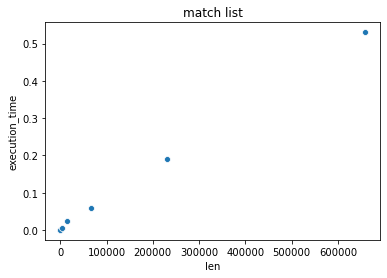

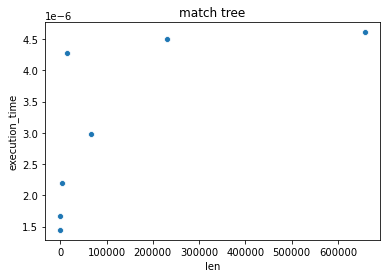

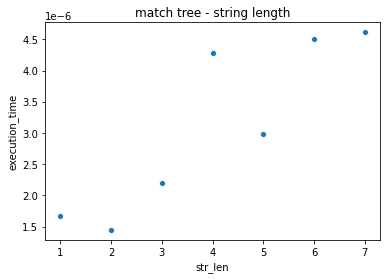

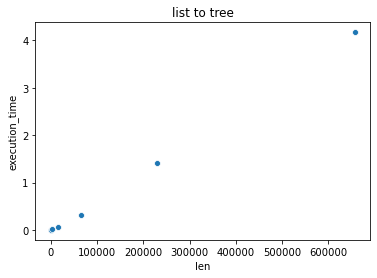

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
sns.scatterplot('len', 'execution_time', data=matchList_stats_df, ax=ax)
ax.set_title('match list')

fig, ax = plt.subplots()
sns.scatterplot('len', 'execution_time', data=matchTree_stats_df, ax=ax)
ax.set_title('match tree')

fig, ax = plt.subplots()
sns.scatterplot('str_len', 'execution_time', data=matchTree_stats_df, ax=ax)
ax.set_title('match tree - string length')

fig, ax = plt.subplots()
sns.scatterplot('len', 'execution_time', data=makeTree_stats_df, ax=ax)
ax.set_title('list to tree')

In [12]:
import pkg_resources
packages=['numpy', 'pandas', 'matplotlib', 'seaborn']
for m in pkg_resources.working_set:
    if m.project_name.lower() in packages:
        print(f"{m.project_name}=={m.version}")

seaborn==0.10.1
pandas==1.0.4
numpy==1.18.1
matplotlib==3.2.1
